In [1]:
import sys, warnings
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

warnings.simplefilter('ignore', UserWarning)

### URL do endpoint SPARQL público do Wikidata

In [2]:
endpoint_url = "https://query.wikidata.org/sparql"

## Consulta SPARQL
> - `?city wdt:P31/wdt:P279* wd:Q515`    → instância (P31) de algo que é (via cadeia de "subclasse de" P279*) 'cidade' (Q515)
> - `?city wdt:P1082 ?population`        → população
> - `?city wdt:P625  ?gps`               → coordenadas (WKT: Point(lon lat))
> - Subconsulta (%i) ordena por população desc e limita em 100; o INCLUDE %i reaproveita o conjunto filtrado.
> - `SERVICE wikibase:label` adiciona rótulos legíveis no idioma do usuário.

In [3]:
query = """#Largest cities of the world
#defaultView:BubbleChart
SELECT ?cityLabel ?population ?gps
WITH {
  SELECT DISTINCT *
  WHERE {
    ?city wdt:P31/wdt:P279* wd:Q515 .
    ?city wdt:P1082 ?population .
    ?city wdt:P625 ?gps .
  }
  ORDER BY DESC(?population)
  LIMIT 100
} AS %i
WHERE {
  INCLUDE %i
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],mul,en" . }
}
ORDER BY DESC(?population)"""

## Função de Consulta
> - Instancia o cliente SPARQL apontando para o endpoint com o User-Agent informado
> - Define a consulta SPARQL
> - Pede o resultado em JSON (também pode ser XML, CSV, etc.)
> - Executa a consulta e converte a resposta para um dict Python

In [4]:
def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

In [5]:
results = get_results(endpoint_url, query)

##### Percorre os bindings (linhas) e imprime cada registro bruto

In [6]:
for result in results["results"]["bindings"]:
    print(result)

{'population': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal', 'type': 'literal', 'value': '32054159'}, 'gps': {'datatype': 'http://www.opengis.net/ont/geosparql#wktLiteral', 'type': 'literal', 'value': 'Point(106.506944444 29.55)'}, 'cityLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Chongqing'}}
{'population': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal', 'type': 'literal', 'value': '26495000'}, 'gps': {'datatype': 'http://www.opengis.net/ont/geosparql#wktLiteral', 'type': 'literal', 'value': 'Point(77.216666666 28.666666666)'}, 'cityLabel': {'xml:lang': 'mul', 'type': 'literal', 'value': 'Delhi'}}
{'population': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal', 'type': 'literal', 'value': '24870895'}, 'gps': {'datatype': 'http://www.opengis.net/ont/geosparql#wktLiteral', 'type': 'literal', 'value': 'Point(121.469166666 31.232222222)'}, 'cityLabel': {'xml:lang': 'mul', 'type': 'literal', 'value': '上海'}}
{'population': {'datatype': 'http://www.w3.or

## Conversão para Tabela (DataFrame)

In [7]:
def bindings_to_dataframe(results):
    rows = []
    for b in results["results"]["bindings"]:
        city = b["cityLabel"]["value"]
        population = int(b["population"]["value"])
        wkt = b["gps"]["value"][6:-1]
        lon, lat = wkt.split(" ")
        rows.append({"Cidade": city, "População": population, "Latitude": lat, "Longitude": lon})
    df = pd.DataFrame(rows).sort_values("População", ascending=False, ignore_index=True)
    return df

In [8]:
df = bindings_to_dataframe(results)

In [9]:
df

,Cidade,População,Latitude,Longitude
0,Chongqing,32054159,29.55,106.506944444
1,Delhi,26495000,28.666666666,77.216666666
2,上海,24870895,31.232222222,121.469166666
3,Greater Mexico City,21905000,19.432519444,-99.133158333
4,北京市,21893095,39.90403,116.407526
...,...,...,...,...
95,Yancheng,6709629,33.35,120.156944444
96,Hengyang,6645243,26.89676,112.58568
97,Taizhou,6622888,28.6583,121.42213
98,Zunyi,6606675,27.70498,106.93363


## Visualizações

### Exemplo 1: Gráfico de Top 20 cidades por população

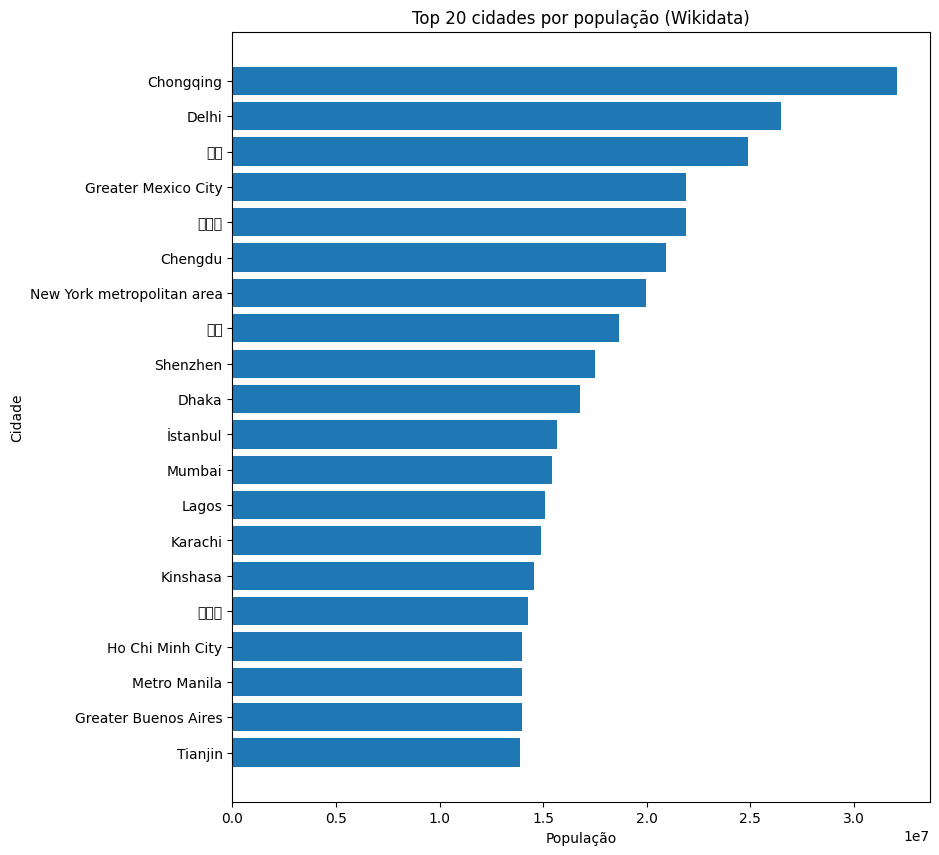

In [10]:
top = df.nlargest(20, "População").iloc[::-1]
plt.figure(figsize=(9, 10))
plt.barh(top["Cidade"], top["População"])
plt.xlabel("População")
plt.ylabel("Cidade")
plt.title("Top 20 cidades por população (Wikidata)")
plt.show()

### Exemplo 2: Mapa das maiores cidades por população

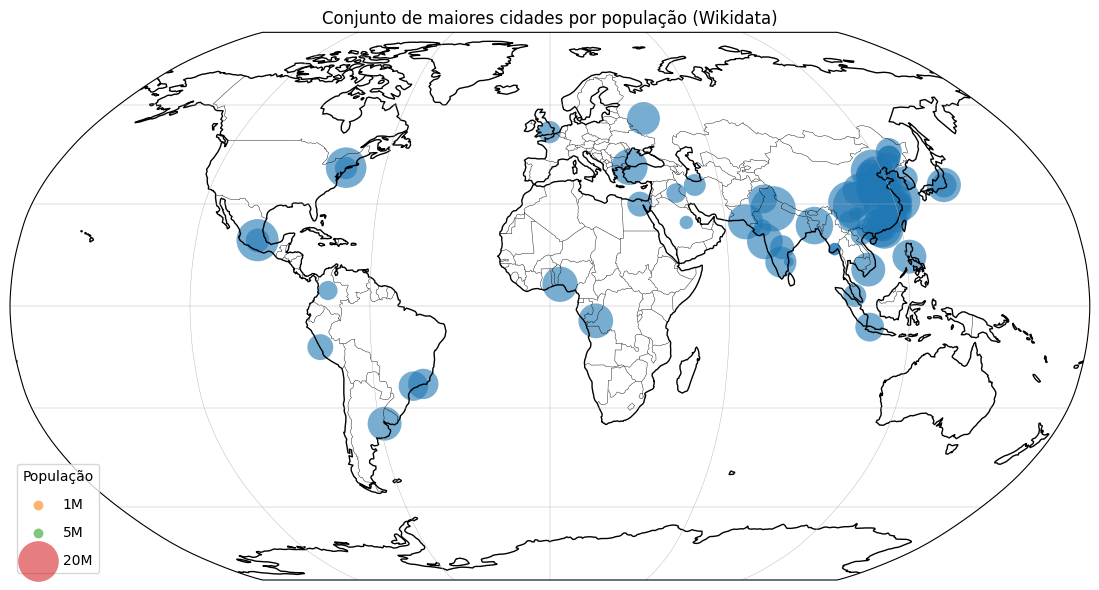

In [11]:
df_ = df.dropna(subset=["Latitude", "Longitude", "População"]).copy()

pop = df_["População"].astype(float).to_numpy()
lon = df_["Longitude"].astype(float).to_numpy()
lat = df_["Latitude"].astype(float).to_numpy()

logp = np.log10(np.clip(pop, 1, None))
lo, hi = logp.min(), logp.max()

if hi > lo:
    sizes = np.interp(logp, (lo, hi), (50.0, 1200.0))
else:
    sizes = np.full_like(logp, 300.0)

mask = np.isfinite(lon) & np.isfinite(lat) & np.isfinite(sizes)
lon, lat, sizes = lon[mask], lat[mask], sizes[mask]

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.gridlines(draw_labels=False, linewidth=0.3)

ax.scatter(lon, lat, s=sizes, alpha=0.6, linewidths=0, transform=ccrs.PlateCarree())

if hi > lo:
    for p, label in [(1e6, "1M"), (5e6, "5M"), (2e7, "20M")]:
        lsize = np.interp(np.log10(p), (lo, hi), (50.0, 1200.0))
        ax.scatter([], [], s=lsize, alpha=0.6, linewidths=0, label=label)
    ax.legend(scatterpoints=1, frameon=True, labelspacing=1, title="População", loc="lower left")

plt.title("Conjunto de maiores cidades por população (Wikidata)")
plt.tight_layout()
plt.savefig("mapa_cidades_populacao.png")
plt.show()